In [8]:
# Crypto prices' analysis
import requests
import json
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [32]:
# Function for CryptoCompare HistoMinute API request

def get_histominute_data(exchange):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym=BTC&tsym=USD&limit=1440&aggregate=1&e={}'
    response = requests.post(url.format(exchange))
    data = json.loads(response.content)
    df = pd.DataFrame.from_dict(data["Data"], orient="columns")
    
    
    return pd.DataFrame(df)

In [56]:
# json list to pandas dataframe
exchange_data = {}
exchanges = ['GDAX', 'BITSTAMP', 'GEMINI', 'OKCOIN', 'KRAKEN']

for exchange in exchanges:
    exchange_data[exchange] = get_histominute_data(exchange)



In [62]:
exchange_data['KRAKEN'].head()

,close,high,low,open,time,volumefrom,volumeto
0,6560.0,6568.9,6560.0,6562.5,1510586460,2.4600,16153.96
1,6556.1,6560.0,6556.1,6560.0,1510586520,4.9600,32504.44
2,6559.3,6560.0,6556.1,6556.1,1510586580,3.8600,25307.33
3,6560.0,6560.0,6559.3,6559.3,1510586640,0.6739,4420.47
4,6569.0,6569.0,6560.0,6560.0,1510586700,5.8700,38507.48


In [63]:
# Function to merge dataframes into a single dataframe
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [64]:
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'close')

In [65]:
btc_usd_datasets.head()

,BITSTAMP,GDAX,GEMINI,KRAKEN,OKCOIN
0,6569.77,6580.01,6542.30,6560.0,6644.67
1,6584.99,6585.00,6551.19,6556.1,6699.59
2,6584.12,6609.99,6551.41,6559.3,6700.00
3,6584.00,6610.00,6558.54,6560.0,6715.86
4,6599.99,6620.00,6585.32,6569.0,6715.86


In [67]:
# Add DateTime Column
btc_usd_datasets["DATE"] = exchange_data['KRAKEN']['time']

In [68]:
# Calculating difference series price data
sum = 0;
for exchange in exchanges:
    sum = sum+btc_usd_datasets[exchange]


In [69]:
# Calculating difference series price data
sum = 0;
for exchange in exchanges:
    sum = sum+btc_usd_datasets[exchange]


In [70]:
dt_new = btc_usd_datasets
dt_new['DATE'] = pd.to_datetime(dt_new['DATE'],unit='s')
dt_new.head()

,BITSTAMP,GDAX,GEMINI,KRAKEN,OKCOIN,DATE
0,6569.77,6580.01,6542.30,6560.0,6644.67,2017-11-13 15:21:00
1,6584.99,6585.00,6551.19,6556.1,6699.59,2017-11-13 15:22:00
2,6584.12,6609.99,6551.41,6559.3,6700.00,2017-11-13 15:23:00
3,6584.00,6610.00,6558.54,6560.0,6715.86,2017-11-13 15:24:00
4,6599.99,6620.00,6585.32,6569.0,6715.86,2017-11-13 15:25:00


In [71]:
dt_new['AVG'] = sum/(len(dt_new.columns)-1)
dt_new.tail()

,BITSTAMP,GDAX,GEMINI,KRAKEN,OKCOIN,DATE,AVG
1436,6589.00,6610.00,6596.30,6644.0,6700.00,2017-11-14 15:17:00,6627.860
1437,6589.00,6597.58,6594.84,6643.0,6700.00,2017-11-14 15:18:00,6624.884
1438,6586.39,6597.59,6594.87,6643.0,6733.41,2017-11-14 15:19:00,6631.052
1439,6604.29,6597.59,6593.22,6643.0,6730.00,2017-11-14 15:20:00,6633.620
1440,6586.10,6597.59,6593.14,6643.0,6730.00,2017-11-14 15:21:00,6629.966


In [72]:
# calculating MSE
dict_mse = {}

for exchange in exchanges:
    dict_mse[exchange] = ((dt_new[exchange] - dt_new['AVG']) ** 2).mean(axis=0)

dict_mse

{'BITSTAMP': 2075.5862250270648,
 'GDAX': 2000.86476488827,
 'GEMINI': 1759.1116044024975,
 'KRAKEN': 586.13157700485681,
 'OKCOIN': 15729.455290079111}

In [73]:
# MSE Dictionary to Dataframe
df_mse = pd.DataFrame.from_dict(dict_mse, orient='index')

In [74]:
df_mse.rename(columns={0:'error'})

,error
GDAX,2000.864765
BITSTAMP,2075.586225
GEMINI,1759.111604
OKCOIN,15729.455290
KRAKEN,586.131577


In [75]:
df_mse = df_mse.rename(columns={0:'error'})

In [76]:
#Normalisation

max_value = df_mse['error'].max()
min_value = df_mse['error'].min()
df_mse['normError']=(df_mse['error'] - min_value) / (max_value - min_value)


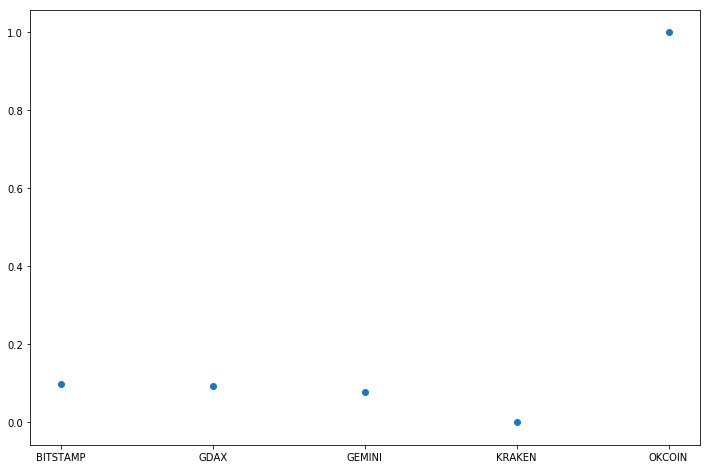

In [77]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(df_mse.index, df_mse['normError'])